In [1]:
# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior() 
  assert tf2.enabled()

import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, MaxPooling2D, Conv3D, MaxPool3D, UpSampling3D, Conv3DTranspose

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from keras.losses import mse, binary_crossentropy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# import matplotlib
# matplotlib.use('Agg')

import matplotlib.pyplot as plt
import glob 

# mode = 'train'   
mode = 'test'

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

import umap
import time
time1 = time.time()

Num GPUs: 8


In [2]:
import gzip

import deephyper
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.decomposition import PCA

from deephyper.nas.metrics import r2, mse

print(f"DeepHyper Version: {deephyper.__version__}")

DeepHyper Version: 0.4.2


In [3]:
######## folder is where parameter matrix is stored ######

def shuffle(X, y):
    shuffleOrder = np.arange(X.shape[0])
    np.random.shuffle(shuffleOrder)
    X = X[shuffleOrder]
    y = y[shuffleOrder]
    return X, y, shuffleOrder

In [4]:
num_epochs = 200
batch_size = 8 #4 #256
learning_rate = 1e-3 #1e-4
decay_rate = 0.1

latent_dim = 8 #16 ###
epsilon_mean = 0.1
epsilon_std = 1e-4 #1e-4

nGrid= 1024
nSamples = 1000

train_test_split= 0.90
from sklearn.utils import shuffle

In [5]:


def load_data(nSamples):
    
    dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/new_void_problem/Example_Ellipsoidal_Void/Run_2/Compiled/Data/'

    
    ell_all_files = glob.glob(dirIn+'/*Ellipse*')
    stress_all_files = glob.glob(dirIn+'/*VonMises*')

    ell_all = np.array([np.load(f) for f in ell_all_files])[:nSamples]
    stress_all = np.array([np.load(f) for f in stress_all_files])[:nSamples]


    split = np.int(train_test_split*ell_all.shape[0])

    train_data = ell_all[0:split, :, :].astype('float32')
    train_target = stress_all[0:split, :, :].astype('float32')
    test_data = ell_all[split:, :, :].astype('float32')
    test_target = stress_all[split:, :, :].astype('float32')

    return (train_data[:, :nGrid, :nGrid], train_target), (test_data[:, :nGrid, :nGrid], test_target)
            


In [6]:
dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/new_void_problem/Example_Ellipsoidal_Void/Run_2/Compiled/Data/'
stress_all_files = glob.glob(dirIn+'/*VonMises*')
stress_all = np.array([np.load(f) for f in stress_all_files])[:nSamples]

In [31]:


def load_data(nSamples):
    
    dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/new_void_problem/Example_Ellipsoidal_Void/Run_2/Compiled/Data/'

    
    ell_all_files = glob.glob(dirIn+'/*Ellipse*')
    stress_all_files = glob.glob(dirIn+'/*VonMises*')

    ell_all = np.array([np.load(f) for f in ell_all_files])[:nSamples]
    stress_all = np.array([np.load(f) for f in stress_all_files])[:nSamples]
    
    max_stress = np.max(stress_all, axis=(1,2))  ## max stress
    

    vol90 = []  ## high vol region
    for ind in range(stress_all.shape[0]):
        vol90i = np.where(stress_all[ind] > 0.9*max_stress[ind], 1, 0).sum()
        vol90 = np.append(vol90, vol90i)

    target_all = np.vstack([max_stress, vol90]).T

    split = int(train_test_split*ell_all.shape[0])

    train_data = ell_all[0:split, :, :].astype('float32')
    # train_target = stress_all[0:split, :, :].astype('float32')
    train_target = target_all[0:split].astype('float32')

    test_data = ell_all[split:, :, :].astype('float32')
    # test_target = stress_all[split:, :, :].astype('float32')
    test_target = target_all[split:].astype('float32')


    return (train_data[:, :nGrid, :nGrid], train_target), (test_data[:, :nGrid, :nGrid], test_target)
            


In [32]:
(train_input, train_target), (test_input, test_target) = load_data(nSamples)

print(train_input.shape)
print(train_target.shape)

num_obj = train_target.shape[1]
 

(180, 1024, 1024)
(180, 2)


In [9]:
loaddata = 'average' ## 'average' or 'log' for different normalization


if loaddata == 'average':
# RESCALING IMAGES
#print(train_images[0,:,:,:,0])
    tmin = train_input.min()
    
    tmax = train_input.max()
    print('old min-max:', tmin, tmax)
    train_images = (train_input - tmin) / (tmax - tmin) # Normalize the images to [-1, 1]
    test_images = (test_input - tmin) / (tmax - tmin)
    print('new min-max:', train_images.min(), train_images.max())

    shape0 = train_images.shape[0]
    swe_train_data = train_images.reshape(shape0, nGrid, nGrid, 1)
    shape0 = test_images.shape[0]
    swe_test_data = test_images.reshape(shape0, nGrid, nGrid, 1)
    
    
    ############################################
    
    tmin = train_target.min()
    
    tmax = train_target.max()
    print('old min-max:', tmin, tmax)
    train_target = (train_target - tmin) / (tmax - tmin) # Normalize the images to [-1, 1]
    test_target = (test_target - tmin) / (tmax - tmin)
    print('new min-max:', train_target.min(), train_target.max())

    shape0 = train_target.shape[0]
    # swe_train_target = train_target.reshape(shape0, nGrid, nGrid, 1)

    shape0 = test_target.shape[0]
    # swe_test_target = test_target.reshape(shape0, nGrid, nGrid, 1)


old min-max: 0.0 1.0
new min-max: 0.0 1.0
old min-max: 446.0 26436118.0
new min-max: 0.0 1.0


In [10]:
def load_data_prepared():
    (train_input, train_target), (test_input, test_target) = load_data(nSamples)
    
    # RESCALING IMAGES

    tmin = train_input.min()
    
    tmax = train_input.max()
    # print('old min-max:', tmin, tmax)
    train_images = (train_input - tmin) / (tmax - tmin) # Normalize the images to [-1, 1]
    test_images = (test_input - tmin) / (tmax - tmin)
    # print('new min-max:', train_images.min(), train_images.max())

    shape0 = train_images.shape[0]
    swe_train_data = train_images.reshape(shape0, nGrid, nGrid, 1)
    shape0 = test_images.shape[0]
    swe_test_data = test_images.reshape(shape0, nGrid, nGrid, 1)
    
    
    ############################################
    # RESCALING TARGETS

    
    tmin = train_target.min()
    
    tmax = train_target.max()
    # print('old min-max:', tmin, tmax)
    train_target = (train_target - tmin) / (tmax - tmin) # Normalize the images to [-1, 1]
    test_target = (test_target - tmin) / (tmax - tmin)
    # print('new min-max:', train_target.min(), train_target.max())
    
    return (swe_train_data, train_target), (swe_test_data, test_target)



In [15]:
def build_and_train_model(config: dict, n_components: int = 2, verbose: bool = 0):
    tf.keras.utils.set_random_seed(42)

    default_config = {
        "activation": "relu",
        "recurrent_activation": "sigmoid",
        "learning_rate": 1e-3,
        "batch_size": 2,
        "epochs": 20,
    }
    default_config.update(config)

    
    (X_train, y_train), (X_valid, y_valid) = load_data_prepared()



    model = tf.keras.Sequential(
        [tf.keras.Input(shape=X_train.shape[1:])] 
        + [tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', strides=2, padding='same')]
        + [tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', strides=2, padding='same')]
        + [tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', strides=4, padding='same')]
        + [tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', strides=4, padding='same')]
        + [tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', strides=4, padding='same')]
        + [tf.keras.layers.Flatten()]
        # + layers
        + [tf.keras.layers.Dense(512**n_components, activation=default_config["activation"])]
        + [tf.keras.layers.Dense(64*n_components, activation=default_config["activation"])]
        + [tf.keras.layers.Dense(32*n_components, activation=default_config["activation"])]
        + [tf.keras.layers.Dense(n_components, activation='linear')]
    )
    


    if verbose:
        model.summary()
        
        
    def metric1(y_true, y_pred):
        squared_difference = tf.square(y_true - y_pred)
        return tf.reduce_mean(squared_difference, axis=0)[0]


    def metric2(y_true, y_pred):
        squared_difference = tf.square(y_true - y_pred)
        return tf.reduce_mean(squared_difference, axis=0)[1]


    optimizer = tf.keras.optimizers.Adam(learning_rate=default_config["learning_rate"])
    model.compile(optimizer, "mse", metrics=[metric1, metric2])

    history = model.fit(
        X_train,
        y_train,
        epochs=default_config["epochs"],
        batch_size=default_config["batch_size"],
        validation_data=(X_valid, y_valid),
        verbose=verbose,
    ).history

    return model, history


In [16]:
# import tensorflow as tf
# x = tf.constant(train_target)
# y = tf.constant(1.1*train_target)
# print(x.shape)

# sd = tf.square(x - y)
# print(sd.shape)
# print(tf.reduce_mean(sd, axis=0)[0], tf.reduce_mean(sd, axis=0)[1])

In [17]:
# tf.reduce_mean(sd, axis=0)

In [18]:
model, history = build_and_train_model(config={}, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 512, 512, 128)     1280      
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 64)      73792     
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 262144)           

In [19]:
-history["val_metric1"][-1]

-0.011759782209992409

In [22]:
from deephyper.problem import HpProblem


problem = HpProblem()
problem.add_hyperparameter(["sigmoid", "tanh", "relu"], "activation", default_value="tanh")
problem.add_hyperparameter((1e-5, 1e-2, "log-uniform"), "learning_rate", default_value=1e-3)
problem.add_hyperparameter((2, 8), "batch_size", default_value=4)
problem.add_hyperparameter((5, 100), "epochs", default_value=20)
problem

Configuration space object:
  Hyperparameters:
    activation, Type: Categorical, Choices: {sigmoid, tanh, relu}, Default: tanh
    batch_size, Type: UniformInteger, Range: [2, 8], Default: 4
    epochs, Type: UniformInteger, Range: [5, 100], Default: 20
    learning_rate, Type: UniformFloat, Range: [1e-05, 0.01], Default: 0.001, on log-scale

In [23]:
from keras.utils.layer_utils import count_params

def run_multi_objective(config):
    # important to avoid memory exploision
    tf.keras.backend.clear_session()
    
    model, history = build_and_train_model(config, verbose=0)

    # return -history["val_loss"][-1], -count_params(model.trainable_weights)
    return -history["val_loss"][-1], -history["val_metric1"][-1], -history["val_metric2"][-1]

In [24]:
from deephyper.search.hps import CBO

search_2 = CBO(problem, run_multi_objective, initial_points=[problem.default_configuration], log_dir="cbo-moo-results", random_state=42)
results_2 = search_2.search(max_evals=20)

/lcrc/project/cosmo_ai/nramachandra/Projects/PRISM/deephyper_repo/deephyper/evaluator/_evaluator.py:101: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

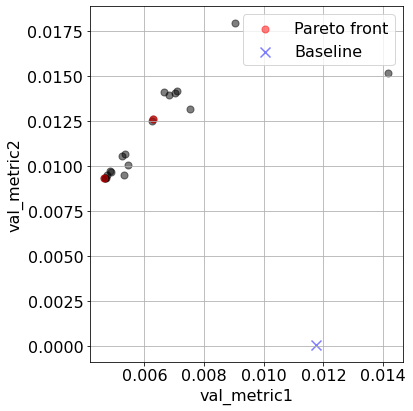

In [25]:
from deephyper.skopt.moo import pareto_front, hypervolume

objvals = -np.asarray(results_2.filter(regex=r"^objective_\d+$").values)
pf_vals = pareto_front(objvals)
plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 16})
plt.scatter(objvals[:, 0], objvals[:, 1], c='k', alpha=0.5, s=50)
plt.scatter(pf_vals[:, 0], pf_vals[:, 1], c='r', alpha=0.5, s=50, label="Pareto front")
plt.scatter(history["val_metric1"][-1], history["val_metric2"][-1], c='b', alpha=0.5, marker='x', s=100, label="Baseline")
plt.xlabel("val_metric1")
plt.ylabel("val_metric2")
# plt.gca().set_yscale('log')
# plt.gca().set_xscale('log')
plt.grid()
plt.legend()
plt.tight_layout()

In [26]:
from deephyper.skopt.moo import non_dominated_set

nds = non_dominated_set(objvals, return_mask=False)
non_dominated_configurations = results_2.iloc[nds]
non_dominated_configurations

,activation,batch_size,epochs,learning_rate,job_id,objective_0,objective_1,objective_2,timestamp_submit,timestamp_gather
17,relu,2,95,0.003468,18,-0.004663,-0.009327,-3.730629e-08,1679.630181,1860.285095
14,relu,2,92,0.007625,15,-0.006295,-0.012591,-1.013514e-08,1279.974769,1455.824676


## Change the scalarization strategy to one that uses multiple weight vectors to scalarize the objective functions.

In [27]:
search_test_func_2 = CBO(problem, run_multi_objective, surrogate_model="GP", moo_scalarization_strategy="rChebyshev", initial_points=[problem.default_configuration], log_dir="cbo-moo-results", random_state=42)
results_test_func_2 = search_test_func_2.search(max_evals=100)

  0%|          | 0/100 [00:00<?, ?it/s]

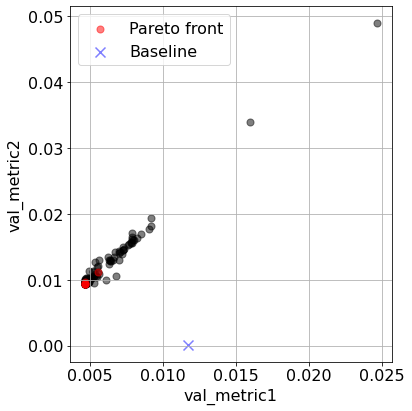

In [28]:
from deephyper.skopt.moo import pareto_front, hypervolume

objvals = -np.asarray(results_test_func_2.filter(regex=r"^objective_\d+$").values)
pf_vals = pareto_front(objvals)
plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 16})
plt.scatter(objvals[:, 0], objvals[:, 1], c='k', alpha=0.5, s=50)
plt.scatter(pf_vals[:, 0], pf_vals[:, 1], c='r', alpha=0.5, s=50, label="Pareto front")
plt.scatter(history["val_metric1"][-1], history["val_metric2"][-1], c='b', alpha=0.5, marker='x', s=100, label="Baseline")
plt.xlabel("val_metric1")
plt.ylabel("val_metric2")
# plt.gca().set_yscale('log')
# plt.gca().set_xscale('log')
plt.grid()
plt.legend()
plt.tight_layout()

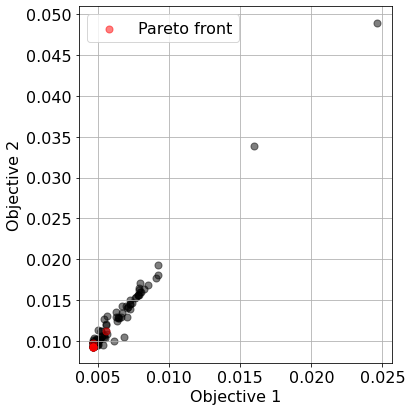

In [29]:
def plot_objective_space(results):
    fv = -np.asarray(results.filter(regex=r"^objective_\d+$").values)
    pf = pareto_front(fv)
    plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 16})
    plt.scatter(fv[:, 0], fv[:, 1], c='k', alpha=0.5, s=50)
    plt.scatter(pf[:, 0], pf[:, 1], c='r', alpha=0.5, s=50, label="Pareto front")
    plt.xlabel("Objective 1")
    plt.ylabel("Objective 2")
    # plt.gca().set_xlim([0, 1])
    # plt.gca().set_ylim([0, 1])
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
plot_objective_space(results_test_func_2)

In [30]:
fv = -np.asarray(results_test_func_2.filter(regex=r"^objective_\d+$").values)
pf = pareto_front(fv)

results_test_func_2.iloc[np.where(fv == pf)]

/tmp/ipykernel_1874613/1602532688.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  results_test_func_2.iloc[np.where(fv == pf)]


,activation,batch_size,epochs,learning_rate,job_id,objective_0,objective_1,objective_2,timestamp_submit,timestamp_gather
